# modesto tutorial

This tutorial shows how to let modesto solve a simple network.

## Imports and other stuff

In [1]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

In [2]:
%matplotlib notebook

In [3]:
logging.basicConfig(level=logging.ERROR,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Exercise.ipynb')

## Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes (besides the name of the node):
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges (besides names of the nodes where the edge starts and stops):
* **Name of the edge**
    

<IPython.core.display.Javascript object>


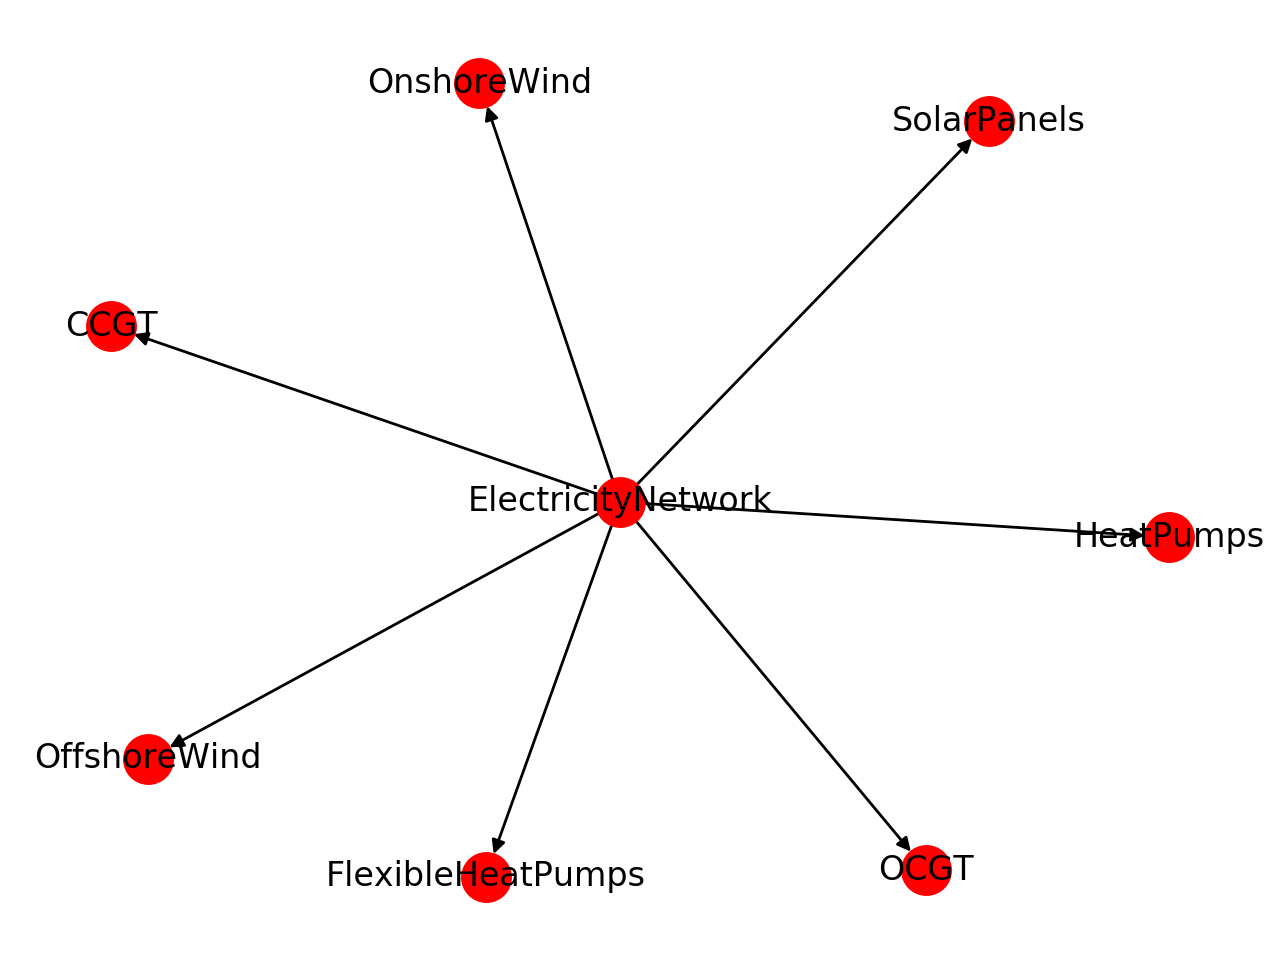

In [114]:
G = nx.DiGraph()

G.add_node('ElectricityNetwork', x=0, y=0, z=0,
           comps={})

# Don't connect gas boilers!
# G.add_node('CondensingGasBoilers', x=1, y=1, z=0,
#            comps={'buildings': 'BuildingFixed',
#                   'DHWtank': 'StorageVariable'})
# G.add_edge('ElectricityNetwork', 'CondensingGasBoilers', name='line1')

G.add_node('HeatPumps', x=1, y=0, z=0,
           comps={'buildings': 'BuildingFixed',
                  'DHWtank': 'StorageVariable'})
G.add_edge('ElectricityNetwork', 'HeatPumps', name='line2')

G.add_node('FlexibleHeatPumps', x=1, y=-1, z=0,
           comps={'buildings': 'RCmodel',
                  'DHWtank': 'StorageVariable'})
G.add_edge('ElectricityNetwork', 'FlexibleHeatPumps', name='line3')
                  
G.add_node('SolarPanels', x=0, y=1, z=0,
           comps={'panels': 'RenewableEnergySource'})
G.add_edge('ElectricityNetwork', 'SolarPanels', name='line4')

G.add_node('OnshoreWind', x=0, y=-1, z=0,
           comps={'turbines': 'RenewableEnergySource'})
G.add_edge('ElectricityNetwork', 'OnshoreWind', name='line5')

G.add_node('OffshoreWind', x=-1, y=1, z=0,
           comps={'turbines': 'RenewableEnergySource'})
G.add_edge('ElectricityNetwork', 'OffshoreWind', name='line6')

G.add_node('CCGT', x=-1, y=0, z=0,
           comps={'plants': 'ProducerVariable'})
G.add_edge('ElectricityNetwork', 'CCGT', name='line7')

G.add_node('OCGT', x=-1, y=1, z=0,
           comps={'plants': 'ProducerVariable'})
G.add_edge('ElectricityNetwork', 'OCGT', name='line8')
                  
    
nx.draw(G, with_labels=True)

## Main parameters

In [148]:
CapWindOn = 1890 * 10 ** 6
CapWindOff = 877 * 10 ** 6
CapSol = 3370 * 10 ** 6
CapCCGT = 11200 * 10 ** 6
CapOCGT = 5000 * 10 ** 6

CO2_price = 10

nBuildings = 10 ** 4
share_HP_noDR = 0.25
share_HP_withDR = 0.25
share_noHP = 0.5

## Setting up modesto

Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types). Possibilities: SimplePipe (= perfect pipe, no losses, no time delays), ExtensivePipe (limited mass flows and heat losses, no time delays) and NodeMethod (heat losses and time delays, but requires mass flow rates to be known in advance)

In [149]:
horizon = 5*24*3600
time_step = 3600
start_time = pd.Timestamp('20140104')
pipe_model = 'SimplePipe'

And create the modesto object

In [150]:
optmodel = Modesto(horizon=horizon, 
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G)

## Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.


### Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load time-variable data from a csv file. In this example, the data that is available in the folder modesto/Data is used.

We use `pkg_resources` to access the example data directory included in the `modesto` library. However, you may also supply your own data, given that it can be transformed into a `pandas` DataFrame with a DatetimeIndex. 

In [151]:
from pkg_resources import resource_filename

DATAPATH = resource_filename('modesto', 'Data')

#### Weather data:

In [152]:
yeardata = pd.read_excel('data/InputData.xlsx', sheet_name='YearData', header=1)
yeardata = yeardata.drop('Time', axis=1)
yeardata.index = pd.DatetimeIndex(start='20140101', periods=len(yeardata), freq='1H',name='Time')

In [153]:
t_amb = yeardata['Tamb'] + 273.15
t_g = yeardata['Tg'] + 273.15
QsolN = yeardata['QsolN']
QsolE = yeardata['QsolE']
QsolS = yeardata['QsolS']
QsolW = yeardata['QsolW']

#### Building data

In [154]:
day_max = yeardata['TmaxDZ'] + 273.15
day_min = yeardata['TminDZ'] + 273.15
night_max = yeardata['TmaxNZ'] + 273.15
night_min = yeardata['TminNZ'] + 273.15
bathroom_max = yeardata['TmaxDZ'] + 273.15
bathroom_min = yeardata['TminDZ'] + 273.15
floor_max = yeardata['TmaxDZ'] + 273.15
floor_min = yeardata['TminDZ'] + 273.15
Q_int_D = yeardata['QintD']
Q_int_N = yeardata['QintN']
mf_DHW = yeardata['mDHW']

#### Producer data

In [155]:
c_f = ut.read_time_data(path=DATAPATH,name='ElectricityPrices/DAM_electricity_prices-2014_BE.csv')['price_BE']

### Changing parameters

In order to solve the problem, all parameters of the optimization probkem need to get a value. 

In [156]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

All of this is now repeated for the two buildings:

In [157]:
condensing_gas_boilers_buildings = {'delta_T': 20,
                          'mult': nBuildings * share_noHP,
                          'heat_profile': yeardata['Qtot1house']
                         }  # TODO weglaten

heat_pumps_buildings = {'delta_T': 20,
              'mult': nBuildings * share_HP_noDR,
              'heat_profile': yeardata['Ptot1house']
             }

flexible_heat_pumps_buildings = {'delta_T': 20,
                       'mult': nBuildings * share_HP_withDR,
                       'night_min_temperature': night_min,
                       'night_max_temperature': night_max,
                       'day_min_temperature': day_min,
                       'day_max_temperature': day_max,
                       'bathroom_min_temperature': bathroom_min,
                       'bathroom_max_temperature': bathroom_max,
                       'floor_min_temperature': floor_min,
                       'floor_max_temperature': floor_max,
                       'model_type': 'SFH_T_5_ins_TAB',
                       'Q_sol_E': QsolE,
                       'Q_sol_W': QsolW,
                       'Q_sol_S': QsolS,
                       'Q_sol_N': QsolN,
                       'Q_int_D': Q_int_D,
                       'Q_int_N': Q_int_N,
                       'Te':  t_amb,
                       'Tg': t_g,
                       'TiD0': 20 + 273.15,
                       'TflD0': 20 + 273.15,
                       'TwiD0': 20 + 273.15,
                       'TwD0': 20 + 273.15,
                       'TfiD0': 20 + 273.15,
                       'TfiN0': 20 + 273.15,
                       'TiN0': 20 + 273.15,
                       'TwiN0': 20 + 273.15,
                       'TwN0': 20 + 273.15,
                       'max_heat': 10000
                       }

condensing_gas_boilers_dhw = {
        'Thi': 60 + 273.15,
        'Tlo': 10 + 273.15,
        'mflo_max': 1,
        'mflo_min': -1,
        'volume': 0.250,
        'ar': 1,
        'dIns': 0.3,
        'kIns': 0.024,
        'heat_stor': 0,
        'mflo_use': mf_DHW * nBuildings * share_noHP
    }

heat_pumps_dhw = {
        'Thi': 60 + 273.15,
        'Tlo': 10 + 273.15,
        'mflo_max': 1,
        'mflo_min': -1,
        'volume': 0.250,
        'ar': 1,
        'dIns': 0.3,
        'kIns': 0.024,
        'heat_stor': 0,
        'mflo_use': mf_DHW * nBuildings * share_HP_noDR
    }  # TODO Add COP for this DHW

flexible_heat_pumps_dhw = {
        'Thi': 60 + 273.15,
        'Tlo': 10 + 273.15,
        'mflo_max': 1,
        'mflo_min': -1,
        'volume': 0.250,
        'ar': 1,
        'dIns': 0.3,
        'kIns': 0.024,
        'heat_stor': 0,
        'mflo_use': mf_DHW * nBuildings * share_HP_withDR
    }


In [158]:
# optmodel.change_params(condensing_gas_boilers_buildings, node='CondensingGasBoilers',
#                        comp='buildings')
# optmodel.change_params(condensing_gas_boilers_dhw, node='CondensingGasBoilers',
#                        comp='DHWtank')
optmodel.change_params(heat_pumps_buildings, node='HeatPumps',
                       comp='buildings')
optmodel.change_params(heat_pumps_dhw, node='HeatPumps',
                       comp='DHWtank')
optmodel.change_params(flexible_heat_pumps_buildings, node='FlexibleHeatPumps',
                       comp='buildings')
optmodel.change_params(flexible_heat_pumps_dhw, node='FlexibleHeatPumps',
                       comp='DHWtank')

The heat generation units:

In [159]:
ccgt = {'efficiency': 0.55,
        'PEF': 2,
        'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
        'fuel_cost': c_f,
        'Qmax': CapCCGT,
        'ramp_cost': 0.01,
        'ramp': CapCCGT / 3600}

ocgt = {'efficiency': 0.35,
        'PEF': 2,
        'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
        'fuel_cost': c_f,
        'Qmax': CapOCGT,
        'ramp_cost': 0.01,
        'ramp': CapOCGT / 3600}

Q_wind_on = yeardata['g_wind_on'] * CapWindOn
Q_wind_off = yeardata['g_wind_off'] * CapWindOff
Q_sol = yeardata['g_wind_off'] * CapSol

onshore_wind_turbines = {'delta_T': 20, 
                        'heat_profile': Q_wind_on}
offshore_wind_turbines = {'delta_T': 20, 
                          'heat_profile': Q_wind_off}
solar_panels = {'delta_T': 20, 
                'heat_profile': Q_sol}

optmodel.change_params(ccgt, 'CCGT', 'plants')
optmodel.change_params(ccgt, 'OCGT', 'plants')
optmodel.change_params(onshore_wind_turbines, 'OnshoreWind', 'turbines')
optmodel.change_params(onshore_wind_turbines, 'OffshoreWind', 'turbines')
optmodel.change_params(onshore_wind_turbines, 'SolarPanels', 'panels')

## Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [160]:
optmodel.compile(start_time=start_time)

In [161]:
optmodel.set_objective('cost')

Finally, the problem can be solved:

Currently, modesto is compatible with two solvers, namely `cplex` and `gurobi`. 

In [162]:
optmodel.solve(tee=True)

Academic license - for non-commercial use only
Changed value of parameter ImproveStartTime to 10.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 10697 rows, 10215 columns and 27727 nonzeros
Coefficient statistics:
  Matrix range     [1e-05, 1e+06]
  Objective range  [5e-03, 1e+00]
  Bounds range     [1e+00, 1e+10]
  RHS range        [1e-02, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 9673 rows and 9066 columns
Presolve time: 0.03s
Presolved: 1024 rows, 1149 columns, 7227 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     878    1.2150612e+05   0.000000e+00   0.000000e+00      0s

Solved in 878 iterations and 0.09 seconds
Optimal objective  1.215061173e+05


0

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [163]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 121506.117252
Energy: 6985.65948529
Cost:   121506.117252


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [166]:
TiD = optmodel.get_result('StateTemperatures', node='FlexibleHeatPumps',
                           comp='buildings', index='TiD', state=True)
TiN = optmodel.get_result('StateTemperatures', node='FlexibleHeatPumps',
                           comp='buildings', index='TiN', state=True)
Q_hea_D = optmodel.get_result('ControlHeatFlows', node='FlexibleHeatPumps',
                                comp='buildings', index='Q_hea_D')
Q_hea_N = optmodel.get_result('ControlHeatFlows', node='FlexibleHeatPumps',
                                comp='buildings', index='Q_hea_N')

Creating plots:

<IPython.core.display.Javascript object>


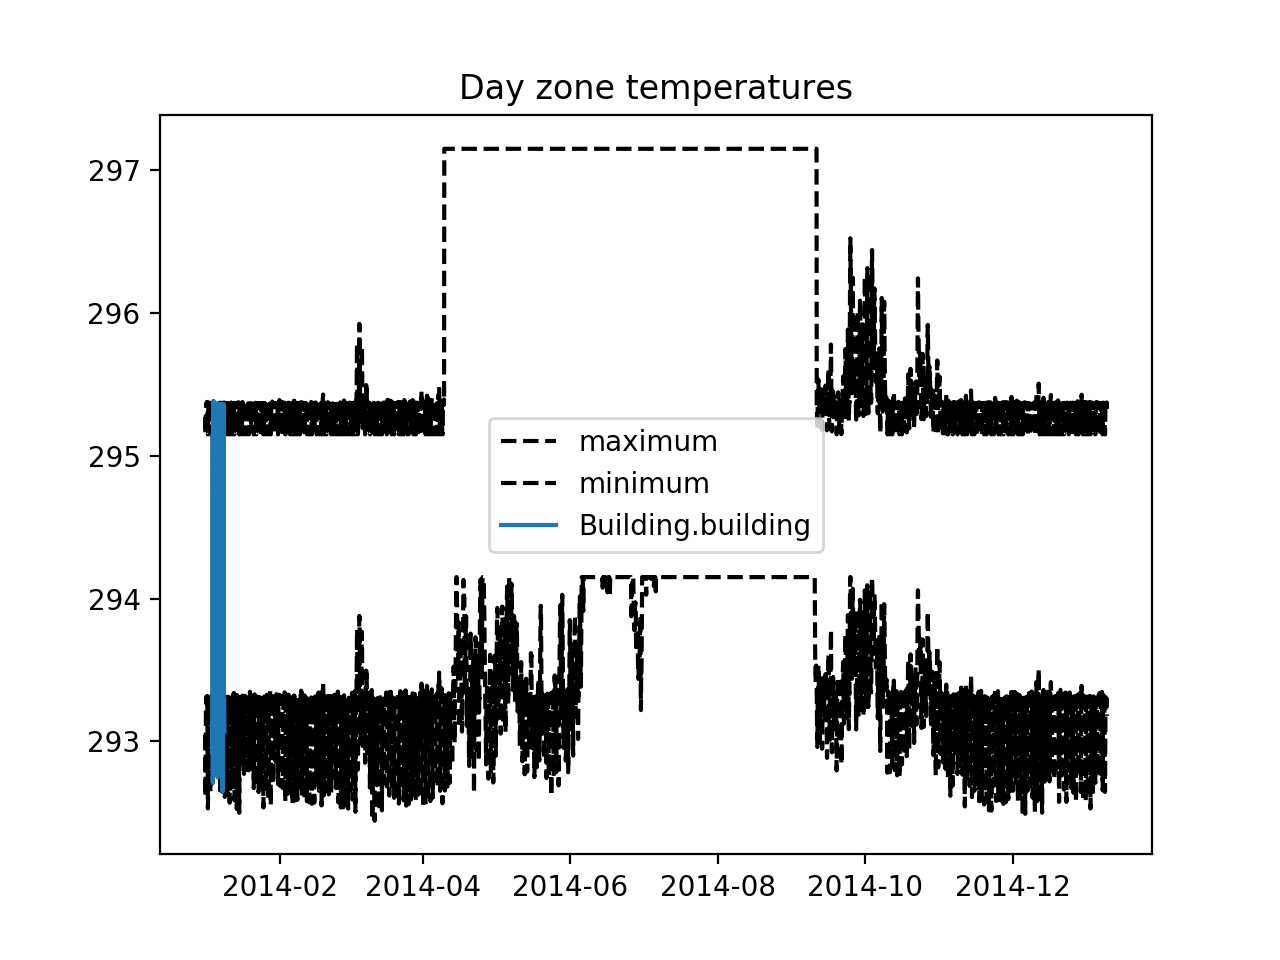

<IPython.core.display.Javascript object>


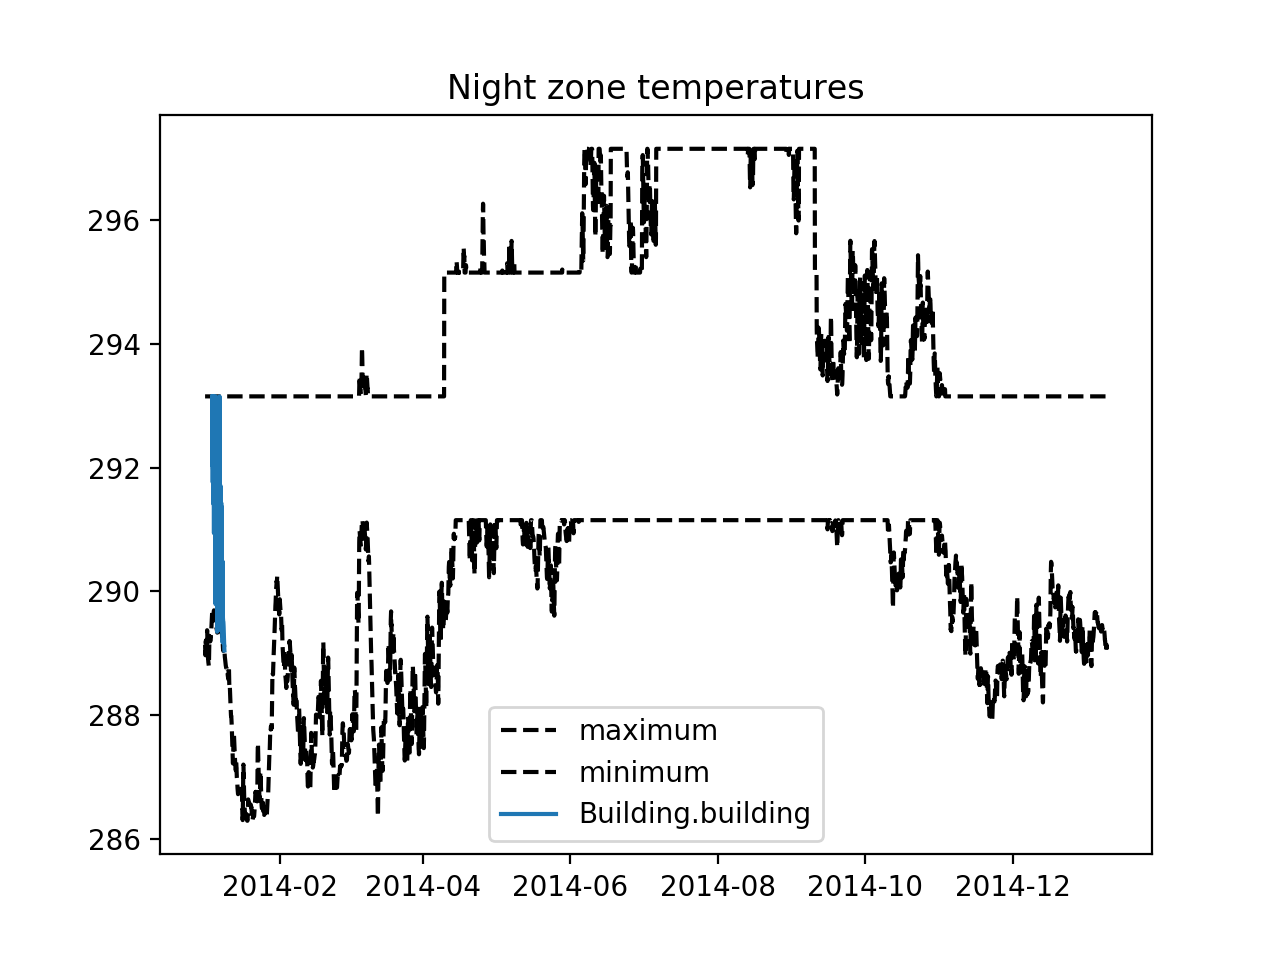

<IPython.core.display.Javascript object>


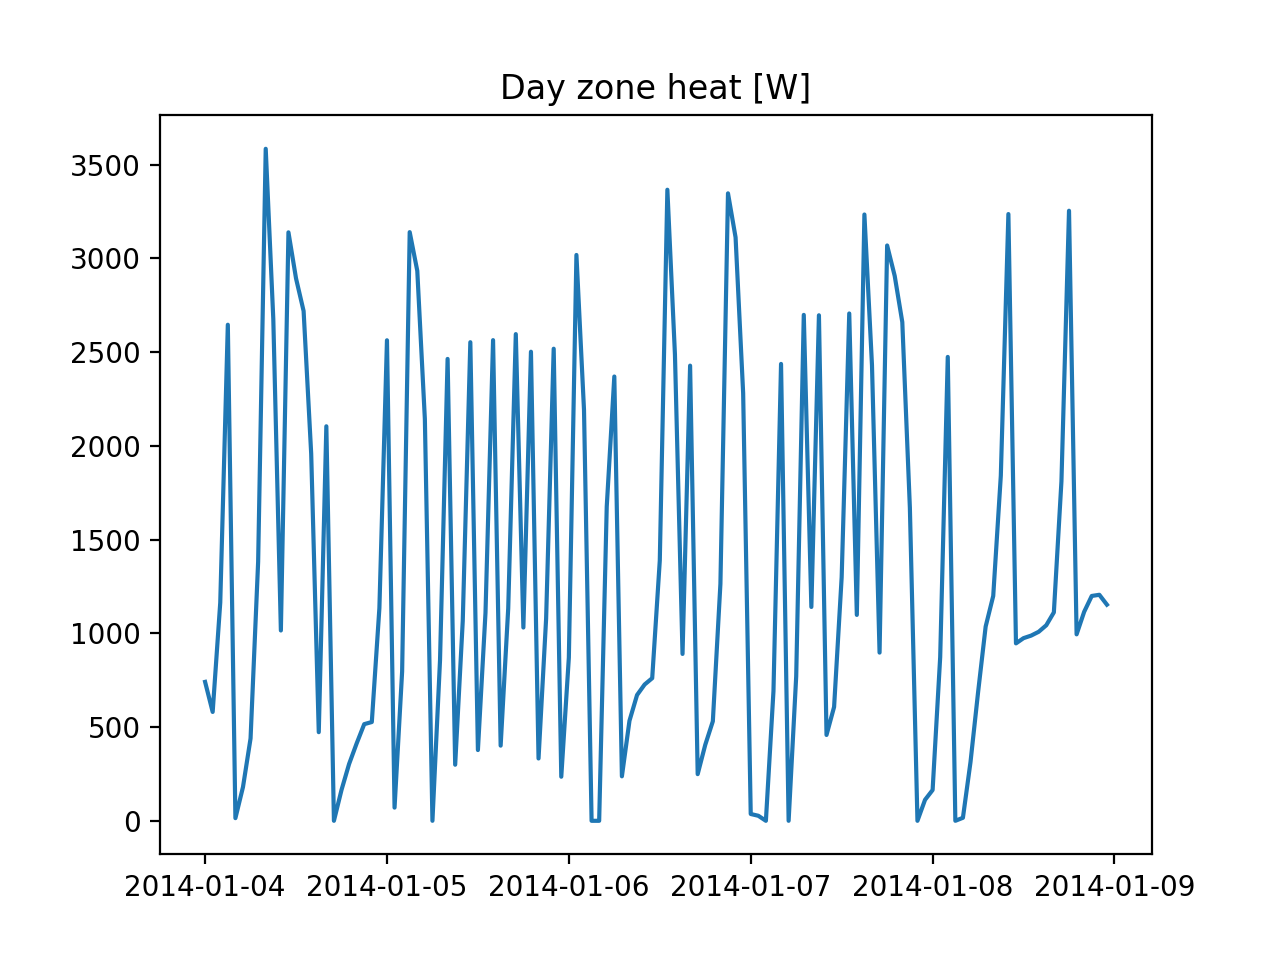

<IPython.core.display.Javascript object>


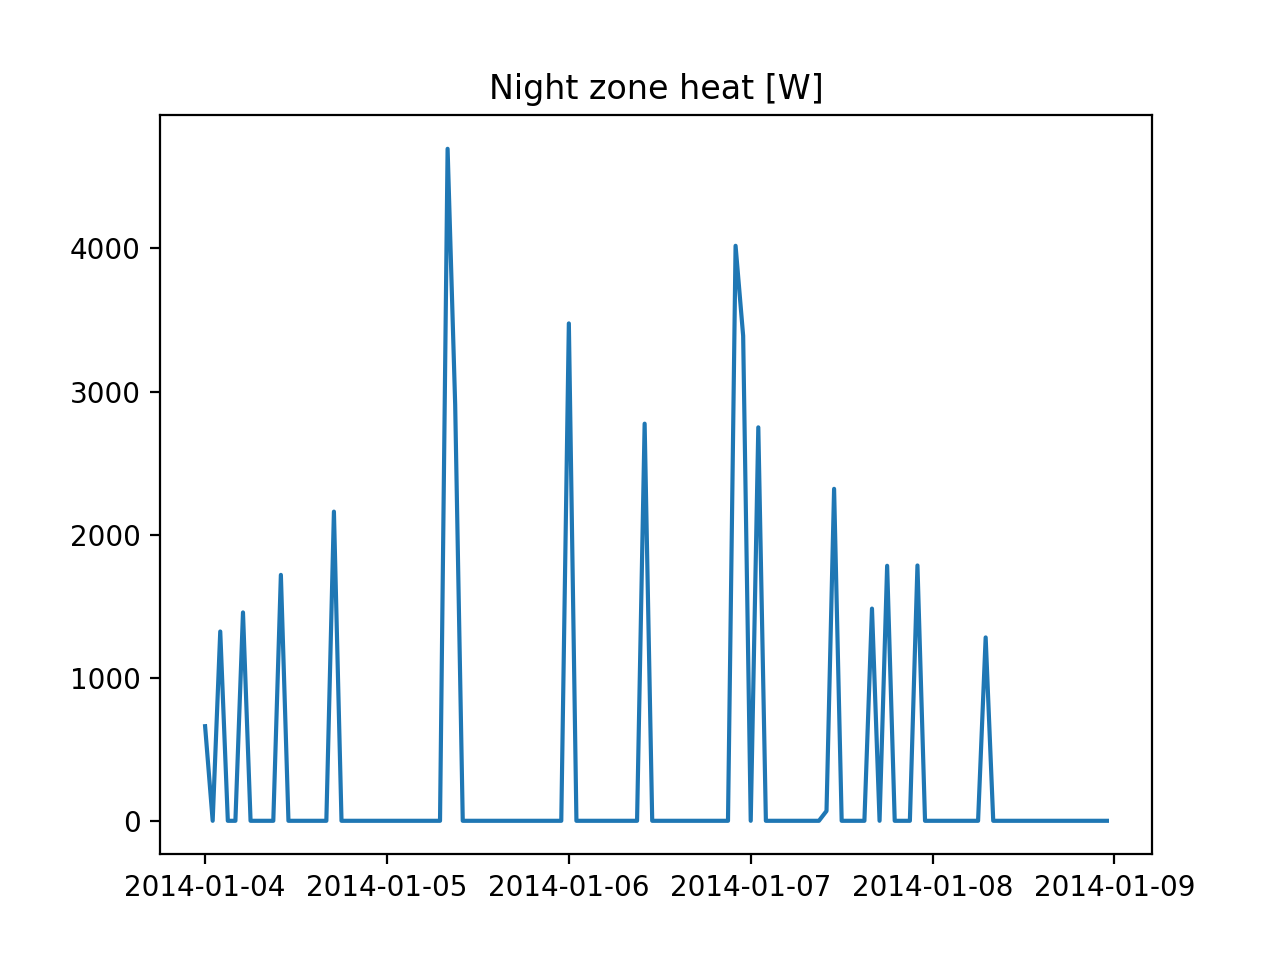

Text(0.5,1,u'Night zone heat [W]')

In [168]:
userprofile = ut.read_period_data(path=DATAPATH, name='UserBehaviour/ISO13790.csv',
                                time_step=time_step, horizon=horizon, start_time=start_time)

# day_max = yeardata['day_max']
# day_min = yeardata['day_min']
# night_max = yeardata['night_max']
# night_min = yeardata['night_min']

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# ax1 = fig1.add_subplot(221)
ax1.plot(day_max, label='maximum', linestyle='--', color='k')
ax1.plot(day_min, label='minimum', linestyle='--', color='k')
ax1.plot(TiD, label='Building.building')
ax1.legend()
ax1.set_title('Day zone temperatures')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(night_max, label='maximum', linestyle='--', color='k')
ax2.plot(night_min, label='minimum', linestyle='--', color='k')
ax2.plot(TiN, label='Building.building')
ax2.legend()
ax2.set_title('Night zone temperatures')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(Q_hea_D)
ax3.set_title('Day zone heat [W]')

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(Q_hea_N)
ax4.set_title('Night zone heat [W]')



## Storage unit

In [ ]:
storage_stored_heat = optmodel.get_result('heat_stor', node='BuildingAndStorage',
                                  comp='storage')
storage_heat_flow = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')

In [ ]:
fig1, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.plot(storage_stored_heat)
ax.set_title('Stored heat [kWh]')
ax2.plot(storage_heat_flow)
ax2.set_title('Heat flow to the tank [kWh]')
ax2.axhline(linestyle='--', color='g')

## Heat generation unit

In [ ]:
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
c_f = ut.read_period_data(path=DATAPATH,
                          name='ElectricityPrices/DAM_electricity_prices-2014_BE.csv',
                          time_step=time_step, horizon=horizon,
                          start_time=start_time)['price_BE']

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1 , sharex=True)
ax.plot(prod_hf)

ax.axhline(y=0, linewidth=2, color='k', linestyle='--')
ax.set_title('Producer heat flows [W]')

ax1.plot(c_f)
ax1.set_title('Fuel price (electricity) euro/MWh')
ax1.legend()
#fig.tight_layout()

The plot clearly shows that the cost objective is followed, with the heat generation unit preferring moments of low electricity price to inject heat into the network.

Looking at the plots of the storage unit, you can see that most of this heat is stored there and used at a later time to keep the buildings sufficiently warm.

## Network efficiency

In [ ]:
# Heat flows
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
storage_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')
waterschei_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                    comp='building')
zwartberg_hf = optmodel.get_result('heat_flow', node='Building',
                                   comp='building')


# Sum of heat flows
prod_e = sum(prod_hf)
storage_e = sum(storage_hf)
waterschei_e = sum(waterschei_hf)
zwartberg_e = sum(zwartberg_hf)

# Efficiency
print '\nNetwork efficiency', (storage_e + waterschei_e + zwartberg_e) / prod_e * 100, '%'
    